In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from scipy.stats import chi2_contingency, spearmanr, pointbiserialr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
import torch.optim as optim
from statsmodels.stats.stattools import durbin_watson
import pingouin as pg
from statsmodels.tsa.seasonal import seasonal_decompose

<h1> 1. Overview of Response vairable and Predictor Variables </h1>

<h2> (1) Distribution of Response Variable and Predictor Variables </h2>

In [ ]:
# Load the dataset
df = pd.read_csv('hour.csv')

# Convert 'dteday' to datetime format
df['dteday'] = pd.to_datetime(df['dteday'])
df['date_index'] = (df['dteday'] - df['dteday'].min()).dt.days
df["datetime"] = pd.to_datetime(df["dteday"]) + pd.to_timedelta(df["hr"], unit="h")
df["timestamp_seconds"] = (df["datetime"] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")

# Response variable
response_var = 'cnt'

# Predictor variables (before selection and transformation; 'instant' is excluded as it is an index'; 'casual' and 'registered' are excluded as the sum is the response variable)
continuous_vars = ['temp', 'atemp', 'hum', 'windspeed']

temporal_vars = ['date_index']
binary_vars = ['holiday', 'workingday']
nominal_categorical = ['season']
ordinal_categorical = ['weathersit']
trend_vars = ['yr']
cyclical_categorical = ['mnth', 'hr', 'weekday']
discrete_vars = temporal_vars + binary_vars + nominal_categorical + ordinal_categorical + trend_vars + cyclical_categorical

predictor_vars = continuous_vars + discrete_vars

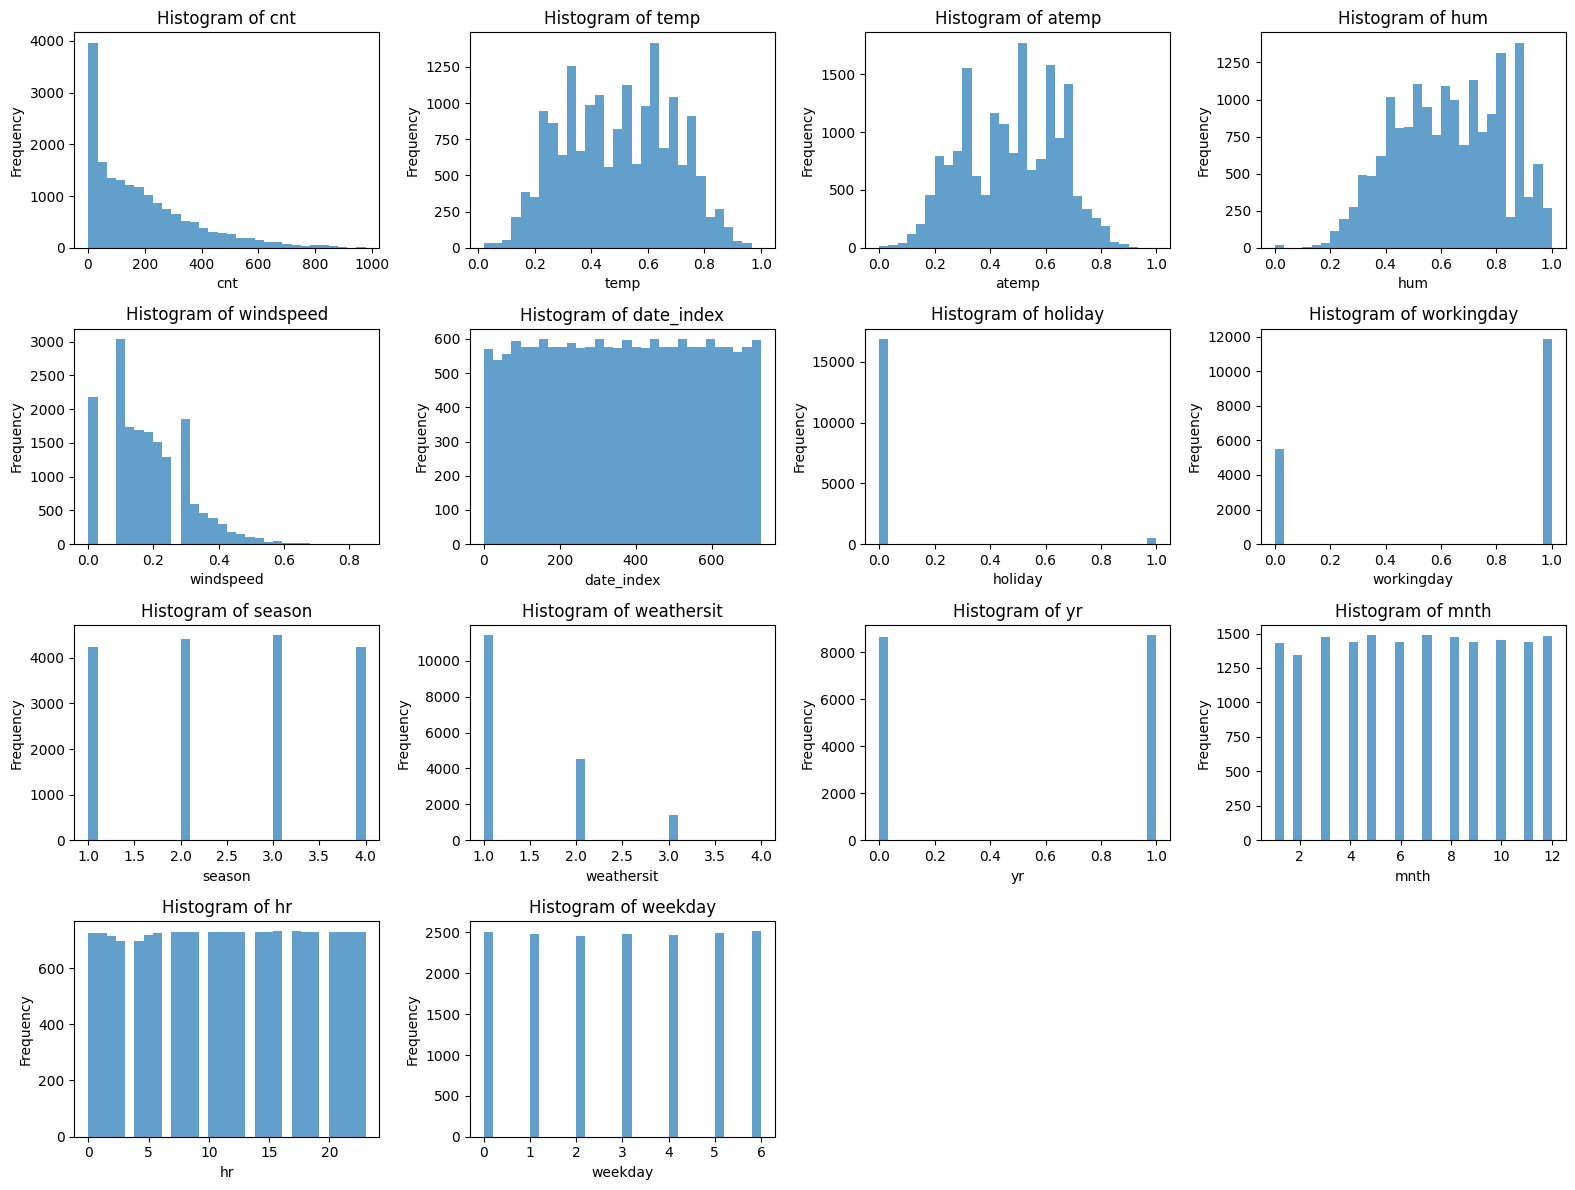

In [ ]:
def features_analysis(df):
    n_features = df.shape[1]
    n_cols = int(np.ceil(np.sqrt(n_features)))
    n_rows = int(np.ceil(n_features / n_cols))
    fig_width = n_cols * 4
    fig_height = n_rows * 3

    plt.figure(figsize=(fig_width, fig_height))
    for i, col in enumerate(df.columns):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.hist(df[col], bins=30, alpha=0.7)
        ax.set_title(f'Histogram of {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Check the distribution of each variable
plot_vars_all = [response_var] + predictor_vars
features_analysis(df[plot_vars_all])

In [ ]:
df[plot_vars_all].describe(include='all')

,cnt,temp,atemp,hum,windspeed,date_index,holiday,workingday,season,weathersit,yr,mnth,hr,weekday
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,189.463088,0.496987,0.475775,0.627229,0.190098,366.172622,0.028770,0.682721,2.501640,1.425283,0.502561,6.537775,11.546752,3.003683
std,181.387599,0.192556,0.171850,0.192930,0.122340,210.072051,0.167165,0.465431,1.106918,0.639357,0.500008,3.438776,6.914405,2.005771
min,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,40.000000,0.340000,0.333300,0.480000,0.104500,184.000000,0.000000,0.000000,2.000000,1.000000,0.000000,4.000000,6.000000,1.000000
50%,142.000000,0.500000,0.484800,0.630000,0.194000,366.000000,0.000000,1.000000,3.000000,1.000000,1.000000,7.000000,12.000000,3.000000
75%,281.000000,0.660000,0.621200,0.780000,0.253700,548.000000,0.000000,1.000000,3.000000,2.000000,1.000000,10.000000,18.000000,5.000000
max,977.000000,1.000000,1.000000,1.000000,0.850700,730.000000,1.000000,1.000000,4.000000,4.000000,1.000000,12.000000,23.000000,6.000000


<h2> (2) Correlation Analysis </h2>

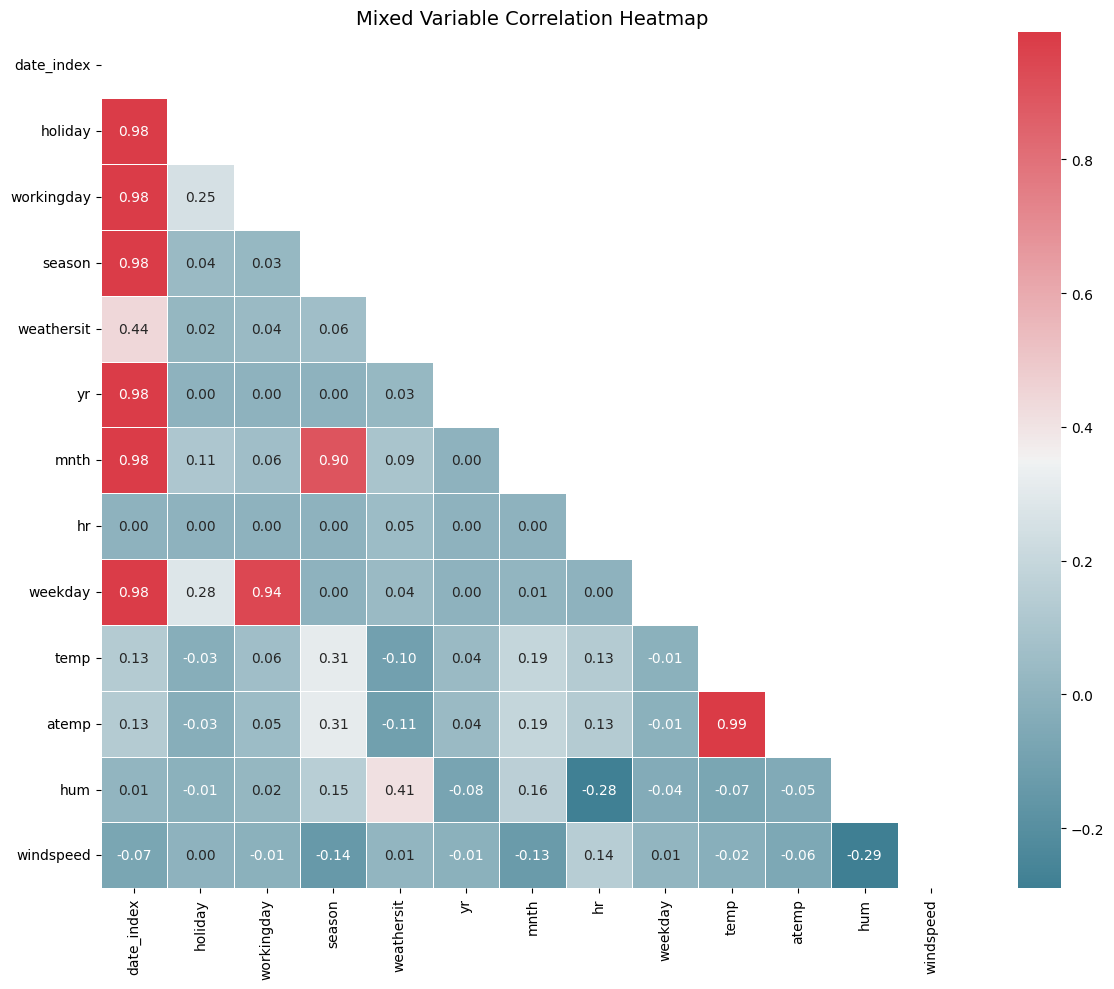

In [ ]:
def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    if n == 0:
        return np.nan
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr - 1), (rcorr - 1))
    if denom <= 0:
        return np.nan  # Avoid division by zero or negative root
    return np.sqrt(phi2corr / denom)

def mixed_correlation_matrix(df, discrete_vars, continuous_vars):
    """Create correlation matrix for mixed variable types."""
    all_vars = discrete_vars + continuous_vars
    n_vars = len(all_vars)
    corr_matrix = np.zeros((n_vars, n_vars))

    for i, var1 in enumerate(all_vars):
        for j, var2 in enumerate(all_vars):
            if i == j:
                corr_matrix[i, j] = 1.0
            elif var1 in continuous_vars and var2 in continuous_vars:
                # Pearson correlation for continuous-continuous
                corr_matrix[i, j] = df[var1].corr(df[var2])
            elif var1 in discrete_vars and var2 in discrete_vars:
                # Cramér's V for discrete-discrete
                corr_matrix[i, j] = cramers_v(df[var1], df[var2])
            else:
                # Mixed types
                if df[var1].nunique() == 2 and var1 in discrete_vars:
                    corr_matrix[i, j] = pointbiserialr(df[var1], df[var2])[0]
                elif df[var2].nunique() == 2 and var2 in discrete_vars:
                    corr_matrix[i, j] = pointbiserialr(df[var2], df[var1])[0]
                else:
                    corr_matrix[i, j] = spearmanr(df[var1], df[var2])[0]

    return pd.DataFrame(corr_matrix, index=all_vars, columns=all_vars)

# Calculate mixed correlation matrix for all variables
corr = mixed_correlation_matrix(df, discrete_vars, continuous_vars).round(2)

# Create correlation heatmap for all variables
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))  # Mask upper triangle
sns.heatmap(
    corr, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True),
    fmt='.2f', linewidths=0.5, mask=mask
)
plt.title('Mixed Variable Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()


In this analysis, we found that there are several predictors highly correlated:

* `temp` and `atemp` (correlation coefficient = 0.99)

* `date_index` with `holiday`, `workingday`, `season`, `yr`, `mnth`, and `weekday`  (correlation coefficient = 0.98)

* `weekday` and `workingday` (correlation coefficient = 0.94)

* `season` and `mnth` (correlation coefficient = 0.90)

<h1> 2. OLS Regression Model </h1>

In [ ]:
# Exclude the last 48 rows for testing
df_train = df.iloc[:-48, :]

# Run OLS regression
X_train = df_train[predictor_vars]
y_train = df_train[response_var]

# Add constant for OLS regression
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     847.2
Date:                Mon, 02 Jun 2025   Prob (F-statistic):               0.00
Time:                        02:31:51   Log-Likelihood:            -1.1047e+05
No. Observations:               17331   AIC:                         2.210e+05
Df Residuals:                   17317   BIC:                         2.211e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.5371      7.419     -3.577      0.0

In [ ]:
class RegressionDiagnostics:
    """
    Wraps common OLS-diagnostic checks in a single, reusable class.

    Parameters
    ----------
    model : statsmodels.regression.linear_model.RegressionResultsWrapper
        A fitted Statsmodels OLS/GLS model.
    X : pandas.DataFrame, optional
        Design matrix; if not supplied, it is taken from `model.model.exog`
        with the column names in `model.model.exog_names`.
    resid_threshold : float, default 1e-5
        Tolerance for the mean-of-residuals check.
    """

    def __init__(self, model, X: pd.DataFrame | None = None, resid_threshold=1e-5):
        self.model = model
        self.residuals = model.resid
        self.fitted = model.fittedvalues
        self.resid_threshold = resid_threshold
        self.influence = OLSInfluence(model)

        if X is None:
            # Rebuild a DataFrame so VIF has column names
            self.X = pd.DataFrame(model.model.exog, columns=model.model.exog_names)
        else:
            self.X = X.copy()

    def check_residual_mean(self) -> bool:
        """Return True if |mean(resid)| < threshold."""
        m = self.residuals.mean()
        print(f"Mean of residuals: {m:.3e}")
        return abs(m) < self.resid_threshold

    def check_linearity(self):
        """Residuals vs fitted values scatter plot."""
        print("Checking linearity …")
        plt.figure(figsize=(8, 6))
        plt.scatter(self.fitted, self.residuals, edgecolor="b", alpha=0.5)
        plt.axhline(0, color="r", linestyle="--")
        plt.xlabel("Fitted values")
        plt.ylabel("Residuals")
        plt.title("Linearity (Residuals vs Fitted)")
        plt.show()

    def check_homoscedasticity(self):
        """Residual spread vs fitted values."""
        print("Checking homoscedasticity …")
        plt.figure(figsize=(8, 6))
        plt.scatter(self.fitted, self.residuals, edgecolor="b", alpha=0.5)
        plt.axhline(0, color="r", linestyle="--")
        plt.xlabel("Fitted values")
        plt.ylabel("Residuals")
        plt.title("Homoscedasticity (Residuals vs Fitted)")
        plt.show()

    def check_normality(self):
        """Q-Q plot of residuals."""
        print("Checking normality …")
        plt.figure(figsize=(10, 6))
        sns.set_style('whitegrid')
        ax = pg.qqplot(
            self.residuals,
            dist='norm',
            confidence=0.95,
            color='blue',
            s=4
        )
        # Add labels to the main plot elements
        lines = ax.get_lines()
        lines[0].set_label('45-degree Reference Line')   # The QQ plot points
        lines[1].set_label('Besting Fitting Regression Line')  # The reference line
        # If confidence intervals are plotted, they are usually in lines[2] and lines[3]
        if len(lines) > 2:
            lines[2].set_label('95% Pointwise CI')
            # lines[3] is usually the other side of the CI, but you can label as needed
        # Add the legend
        ax.legend()
        ax.set_xlabel('Normal Quantiles')
        ax.set_ylabel('Studentized Residuals')
        plt.show()

    def check_independence(self):
        """Durbin-Watson statistic: ~2 ⇒ no autocorr."""
        print("Checking independence of residuals …")
        dw = durbin_watson(self.residuals)
        print(
            f"Durbin-Watson statistic: {dw:.2f}  "
            "(≈2 → no autocorr.; <2 → positive; >2 → negative)"
        )
        return dw

    def outliers_in_predictors(self, show=True) -> np.ndarray:
        """Return indices with leverage > 2(p+1)/n (and plot if `show`)."""
        print("Checking for outliers in predictors …")
        h = self.influence.hat_matrix_diag
        lev_thr = 2 * (self.model.df_model + 1) / self.model.nobs
        if show:
            plt.figure(figsize=(8, 6))
            plt.stem(h, basefmt=" ")
            plt.axhline(lev_thr, color="r", linestyle="--")
            plt.title("Leverage values (hat‑diag)")
            plt.xlabel("Observation")
            plt.ylabel("Hat value")
            plt.show()
        return np.where(h > lev_thr)[0]

    def outliers_in_response(self, show=True) -> np.ndarray:
        """Return indices with |studentized resid| > 2 (and plot if `show`)."""
        print("Checking for outliers in response …")
        stud = self.influence.resid_studentized_external
        if show:
            plt.figure(figsize=(8, 6))
            plt.stem(np.abs(stud), basefmt=" ")
            plt.axhline(2, color="r", linestyle="--")
            plt.title("|Studentized residuals|")
            plt.xlabel("Observation")
            plt.ylabel("|Studentized resid.|")
            plt.show()
        return np.where(np.abs(stud) > 2)[0]

    def get_influence_indices(self):
        """Get indices of all influential points."""
        print("Getting indices of all influential points …")
        # Get indices of all influential points by intersection of the outliers in predictors and response
        idx = np.intersect1d(
            self.outliers_in_predictors(show=False), self.outliers_in_response(show=False)
        )
        return idx

    def check_multicollinearity(self, show=True) -> None:
        """Return VIF table and optionally plot, highlighting features with VIF > 1000."""
        print("Checking multicollinearity …")

        vif_data = [
            variance_inflation_factor(self.X.values, i) for i in range(self.X.shape[1])
        ]

        vif = pd.DataFrame({
            "Feature": self.X.columns,
            "VIF": vif_data,
        })

        # Filter features with VIF > 1000
        high_vif = vif[vif["VIF"] > 1000]

        print("\nAll VIF values:")
        print(vif)

        if not high_vif.empty:
            print("\nFeatures with VIF > 1000:")
            print(high_vif)
        else:
            print("\nNo feature with VIF > 1000 detected.")

        if show:
            plt.figure(figsize=(8, 6))
            sns.barplot(y="Feature", x="VIF", data=vif)
            plt.title("Variance Inflation Factors (VIF)")
            plt.show()
        return high_vif

    def run_all(self):
        """Execute every diagnostic in a sensible order."""
        print("-" * 60)
        print("RESIDUAL MEAN OK:", self.check_residual_mean())
        print("-" * 60)
        self.check_linearity()
        print("-" * 60)
        self.check_homoscedasticity()
        print("-" * 60)
        self.check_normality()
        print("-" * 60)
        self.check_independence()
        print("-" * 60)
        self.check_multicollinearity()
        print("-" * 60)
        self.outliers_in_predictors()
        print("-" * 60)
        self.outliers_in_response()
        print("-" * 60)
        print("Influential points (indices):")
        print(self.get_influence_indices())
        print("-" * 60)

Mean of residuals: -1.252e-11
Checking linearity …


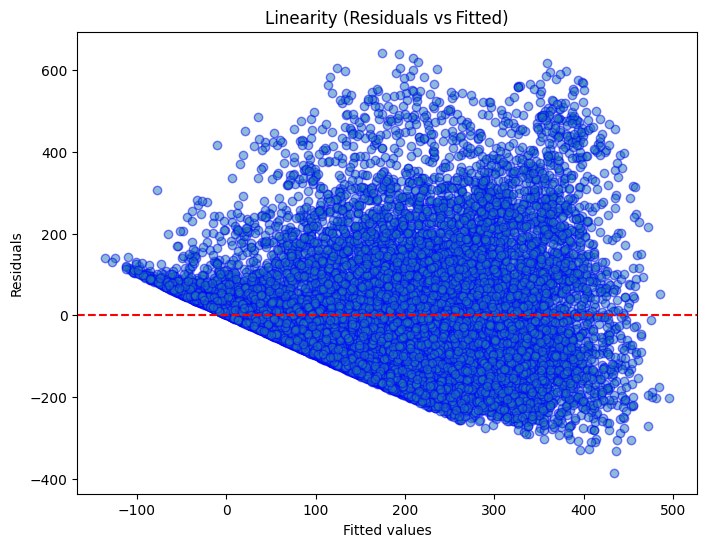

Checking homoscedasticity …


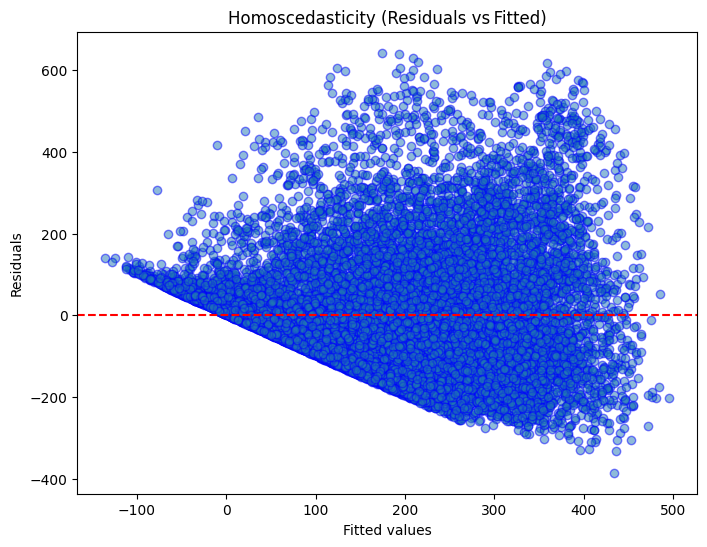

Checking normality …


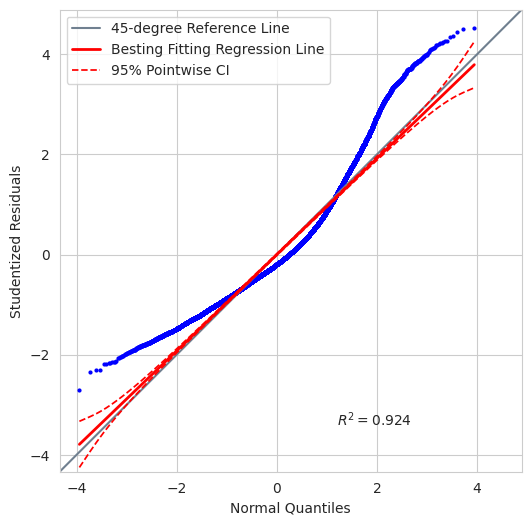

Checking multicollinearity …

All VIF values:
       Feature         VIF
0        const   47.325405
1         temp   43.626227
2        atemp   43.832456
3          hum    1.528543
4    windspeed    1.196886
5   date_index  572.613787
6      holiday    1.083223
7   workingday    1.073847
8       season    3.690994
9   weathersit    1.282059
10          yr  437.654716
11        mnth  145.897929
12          hr    1.123448
13     weekday    1.017938

No feature with VIF > 1000 detected.


,Feature,VIF


In [ ]:
diagnostics = RegressionDiagnostics(model)
diagnostics.check_residual_mean()
diagnostics.check_linearity()
diagnostics.check_homoscedasticity()
diagnostics.check_normality()
diagnostics.check_multicollinearity(show=False)

Based on the diagnostic results, the OLS regression model that includes all predictors directly demonstrates the following:

* The model satisfies the assumption of zero-mean residuals.

* The model violates the assumption of homoscedasticity.

* The model violates the assumption of normality of residuals.

* There are no severe multicollinearity among the predictors.

In [ ]:
# Export the dataset with selected variables
df[[response_var] + predictor_vars + ['timestamp_seconds']].to_csv('hour_base.csv', index=False)

<h1> 2. SOTA model wo/ Statistical Feature Engineering </h1>

The following SOTA model directly uses the predictor variables without further transformation.

<h1> 3. SOTA model w/ Statistical Feature Engineering </h1>

<h2> (1) Feature Transformation </h2>

In [ ]:
# Select the relevant columns for finding the best OLS model that follows the assumptions
df_train_model = df_train[predictor_vars + [response_var]]

a. Feature transformation with time-series approaches

In [ ]:
def engineer_features(df, continuous_vars):
    df = df.copy()

    # Cyclical encoding
    def cyclical_encode(df, col, period):
        df[f'{col}_sin'] = np.sin(df[col] * 2 * np.pi / period)
        df[f'{col}_cos'] = np.cos(df[col] * 2 * np.pi / period)
        return df

    for col, period in [('mnth', 12), ('hr', 24), ('weekday', 7)]:
        df = cyclical_encode(df, col, period)

    # Lag features
    for lag in [1, 2, 3, 24]:
        df[f'cnt_lag_{lag}'] = df['cnt'].shift(lag)

    for lag in [1, 3, 6]:
        for var in ['temp', 'hum']:
            df[f'{var}_lag_{lag}'] = df[var].shift(lag)

    # Rolling features
    for window in [3, 6, 12, 24, 168]:
        df[f'cnt_rolling_mean_{window}'] = df['cnt'].rolling(window, min_periods=1).mean()
        df[f'cnt_rolling_std_{window}'] = df['cnt'].rolling(window, min_periods=1).std()
        df[f'temp_rolling_mean_{window}'] = df['temp'].rolling(window, min_periods=1).mean()
        df[f'hum_rolling_mean_{window}'] = df['hum'].rolling(window, min_periods=1).mean()

    # Rush hour indicators
    df['is_morning_rush'] = ((df['hr'] >= 7) & (df['hr'] <= 9)).astype(int)
    df['is_evening_rush'] = ((df['hr'] >= 17) & (df['hr'] <= 19)).astype(int)

    # Seasonal decomposition (trend + seasonal only)
    for var in ['temp', 'atemp']:
        result = seasonal_decompose(df[var], model='additive', period=24, extrapolate_trend='freq')
        df[f'{var}_trend'] = result.trend
        df[f'{var}_seasonal'] = result.seasonal

    # Interaction: temperature × season
    for season in [1, 2, 3, 4]:
        df[f'temp_season_{season}'] = df['temp'] * (df['season'] == season).astype(int)

    # Feature lists
    cyclical_features = [col for col in df.columns if any(key in col for key in ['mnth_', 'hr_', 'weekday_'])]
    lag_features = [col for col in df.columns if 'lag' in col]
    rolling_features = [col for col in df.columns if 'rolling' in col]
    time_features = ['is_morning_rush', 'is_evening_rush']
    decomp_features = [col for col in df.columns if 'trend' in col or 'seasonal' in col]
    interaction_features = [col for col in df.columns if 'temp_season' in col or 'weather_workday' in col]

    engineered_features = (cyclical_features + lag_features + rolling_features +
                           time_features + decomp_features + interaction_features)

    # Scaling
    scaler = StandardScaler()
    to_scale = [col for col in continuous_vars + engineered_features if col not in cyclical_features + time_features]
    df[to_scale] = scaler.fit_transform(df[to_scale].fillna(0))

    return df, engineered_features

In [ ]:
df_train_model, _ = engineer_features(df_train_model, continuous_vars)
df_train_model.describe(include='all')

,temp,atemp,hum,windspeed,date_index,holiday,workingday,season,weathersit,yr,...,is_morning_rush,is_evening_rush,temp_trend,temp_seasonal,atemp_trend,atemp_seasonal,temp_season_1,temp_season_2,temp_season_3,temp_season_4
count,1.733100e+04,1.733100e+04,1.733100e+04,1.733100e+04,17331.000000,17331.00000,17331.000000,17331.000000,17331.000000,17331.000000,...,17331.000000,17331.000000,1.733100e+04,1.733100e+04,1.733100e+04,1.733100e+04,1.733100e+04,1.733100e+04,1.733100e+04,1.733100e+04
mean,-2.623896e-17,7.871687e-17,-3.443863e-16,7.215713e-17,365.166349,0.02885,0.683227,2.505799,1.425307,0.501183,...,0.125498,0.125786,3.083077e-16,1.686058e-17,-2.033519e-16,2.695643e-17,-1.738331e-16,1.115156e-16,-5.903765e-17,7.871687e-17
std,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,209.489513,0.16739,0.465232,1.105621,0.639716,0.500013,...,0.331292,0.331618,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00
min,-2.484065e+00,-2.777048e+00,-3.250209e+00,-1.553881e+00,0.000000,0.00000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,-2.416880e+00,-1.677238e+00,-2.497791e+00,-1.710438e+00,-5.140651e-01,-5.601002e-01,-5.849194e-01,-5.394371e-01
25%,-8.200845e-01,-8.344185e-01,-7.639815e-01,-6.989044e-01,184.000000,0.00000,0.000000,2.000000,1.000000,0.000000,...,0.000000,0.000000,-8.666966e-01,-1.056949e+00,-8.458495e-01,-1.012375e+00,-5.140651e-01,-5.601002e-01,-5.849194e-01,-5.394371e-01
50%,1.190546e-02,4.859509e-02,1.296479e-02,3.334864e-02,365.000000,0.00000,1.000000,3.000000,1.000000,1.000000,...,0.000000,0.000000,3.510399e-02,1.020373e-01,9.410781e-02,-9.455058e-03,-5.140651e-01,-5.601002e-01,-5.849194e-01,-5.394371e-01
75%,8.438955e-01,8.435987e-01,7.899110e-01,5.217900e-01,546.000000,0.00000,1.000000,3.000000,2.000000,1.000000,...,0.000000,0.000000,8.661304e-01,9.845816e-01,8.240020e-01,9.687809e-01,-5.140651e-01,4.100355e-01,1.138656e+00,-5.394371e-01
max,2.611874e+00,3.051424e+00,1.929432e+00,5.406204e+00,728.000000,1.00000,1.000000,4.000000,4.000000,1.000000,...,1.000000,1.000000,2.082990e+00,1.100974e+00,2.401983e+00,1.125236e+00,4.586414e+00,3.239598e+00,2.606886e+00,3.428368e+00


In [ ]:
# Select predictors and response
y_train_transformed = df_train_model['cnt']
X_train_transformed = df_train_model.drop(columns=['cnt'])

# Add constant for OLS regression
X_train_transformed = sm.add_constant(X_train_transformed)
model_transformed = sm.OLS(y_train_transformed, X_train_transformed).fit()
print(model_transformed.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.561e+08
Date:                Mon, 02 Jun 2025   Prob (F-statistic):               0.00
Time:                        02:32:42   Log-Likelihood:                -614.15
No. Observations:               17331   AIC:                             1346.
Df Residuals:                   17272   BIC:                             1804.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   189.70

Mean of residuals: 1.883e-12
Checking linearity …


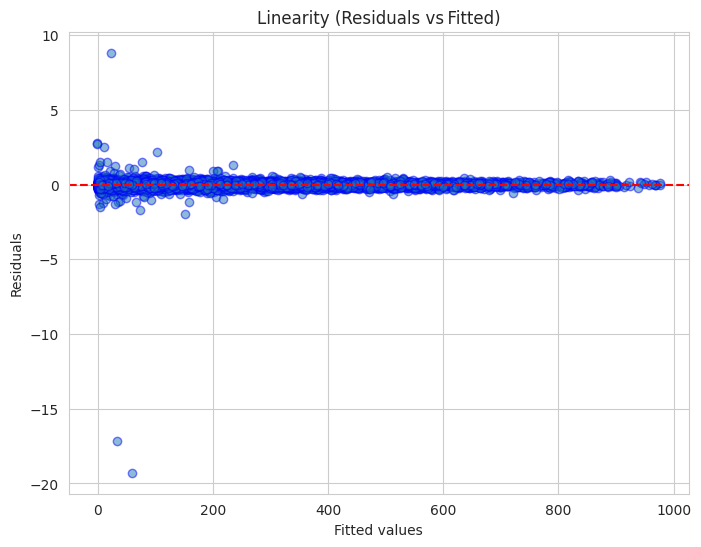

Checking homoscedasticity …


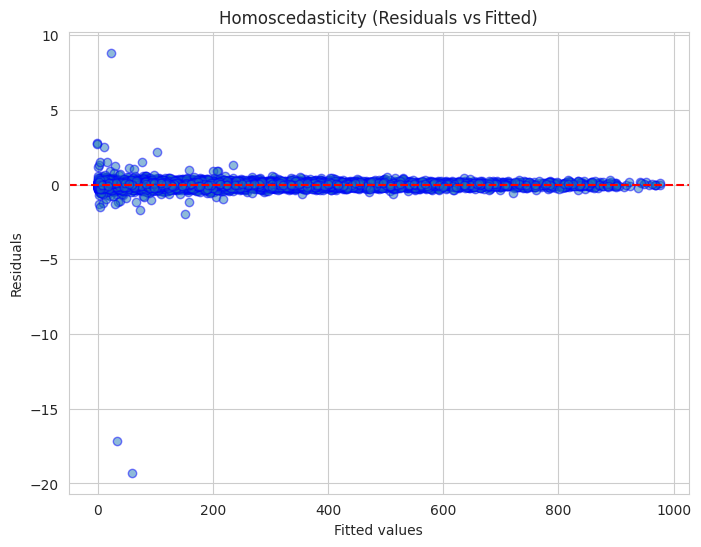

Checking normality …


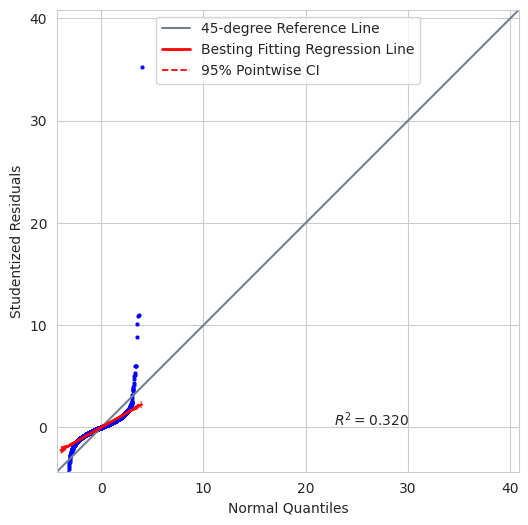

Checking for outliers in predictors …


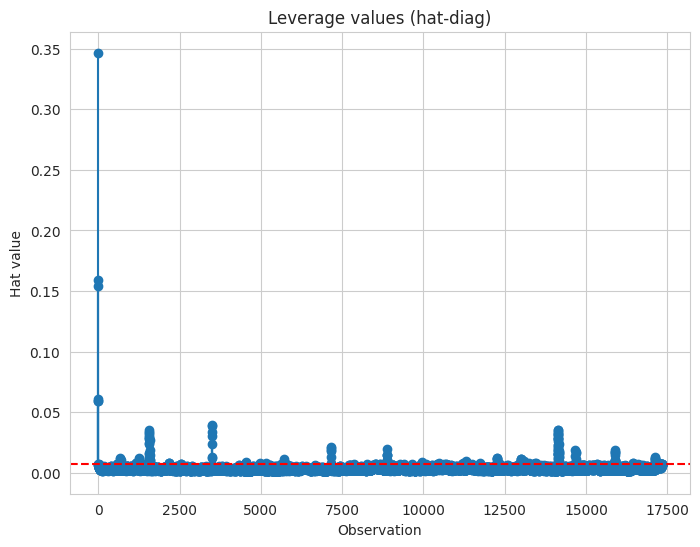

Checking for outliers in response …


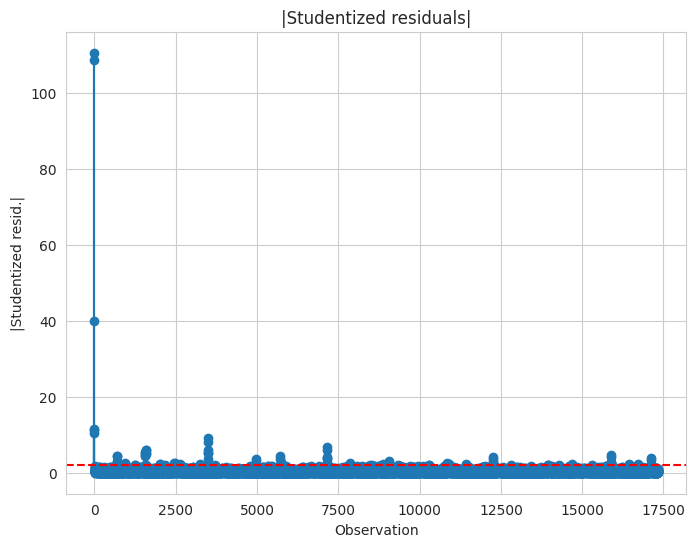

Checking multicollinearity …


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



All VIF values:
                  Feature          VIF
0                   const   120.427375
1                    temp          inf
2                   atemp   111.551222
3                     hum    58.377997
4               windspeed     1.351387
5              date_index   595.221799
6                 holiday     1.240489
7              workingday     3.381613
8                  season    18.417276
9              weathersit     1.493093
10                     yr   455.495433
11                   mnth   151.745399
12                     hr     3.517431
13                weekday     3.007810
14               mnth_sin     8.143212
15               mnth_cos    12.652654
16                 hr_sin     9.097496
17                 hr_cos     5.667355
18            weekday_sin     3.161544
19            weekday_cos     3.143697
20              cnt_lag_1    40.404602
21              cnt_lag_2    13.352296
22              cnt_lag_3    13.453477
23             cnt_lag_24     3.988826
24      

In [ ]:
diagnostics = RegressionDiagnostics(model_transformed)
diagnostics.check_residual_mean()
diagnostics.check_linearity()
diagnostics.check_homoscedasticity()
diagnostics.check_normality()
diagnostics.outliers_in_predictors()
diagnostics.outliers_in_response()
h_vif = diagnostics.check_multicollinearity(show=False)

The model after feature transformation with time-series approaches demonstrates the following:
* The model satisfies the assumption of zero-mean residuals.
* The model violates the assumption of homoscedasticity.
* The model violates the assumption of normality of residuals.
* There are significant outliers in predictors and response variable.
* There exist severe multicollinearity among the predictors.

(b) Remove outliers

In [ ]:
# Remove outliers based on diagnostics
outliers_indices = diagnostics.get_influence_indices()
y_train_transformed = y_train_transformed.drop(index=outliers_indices)
X_train_transformed = X_train_transformed.drop(index=outliers_indices)

Getting indices of all influential points …
Checking for outliers in predictors …
Checking for outliers in response …


(c) Remove highly correlated features

In [ ]:
def iterative_vif_filter(X, thresh=1000):
    """Iteratively remove features with VIF above the threshold."""
    print("Checking multicollinearity iteratively...")
    X = X.copy()

    # Ensure numeric-only and remove near-constant columns
    X = X.select_dtypes(include=[np.number])

    # Exclude const from VIF-based dropping
    exclude = {'const'}
    check_cols = [col for col in X.columns if col not in exclude]

    dropped = True
    while dropped and check_cols:
        dropped = False
        vif = pd.Series(
            [variance_inflation_factor(X[check_cols].values, i) for i in range(len(check_cols))],
            index=check_cols
        )
        max_vif = vif.max()
        if max_vif > thresh:
            drop_col = vif.idxmax()
            print(f"Dropping '{drop_col}' with VIF: {max_vif:.2f}")
            X = X.drop(columns=[drop_col])
            check_cols.remove(drop_col)
            dropped = True

    # Return final list of retained columns (including const if originally present)
    return X.columns.tolist()

In [ ]:
selected_feature = iterative_vif_filter(X_train_transformed, thresh=1000)

Checking multicollinearity iteratively...


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping 'temp' with VIF: inf
Dropping 'temp_rolling_mean_3' with VIF: 4426.92
Dropping 'temp_rolling_mean_6' with VIF: 2728.50
Dropping 'date_index' with VIF: 2379.60


(d) Final model

In [ ]:
# Run OLS regression with selected features to check diagnostics
X_train_transformed = X_train_transformed[selected_feature] # const is already included in the model
model_sota_m = sm.OLS(y_train_transformed, X_train_transformed).fit()
print(model_sota_m.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.225e+31
Date:                Mon, 02 Jun 2025   Prob (F-statistic):               0.00
Time:                        03:23:19   Log-Likelihood:             4.5944e+05
No. Observations:               17275   AIC:                        -9.188e+05
Df Residuals:                   17219   BIC:                        -9.183e+05
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   189.73

Mean of residuals: 1.368e-13
Checking linearity …


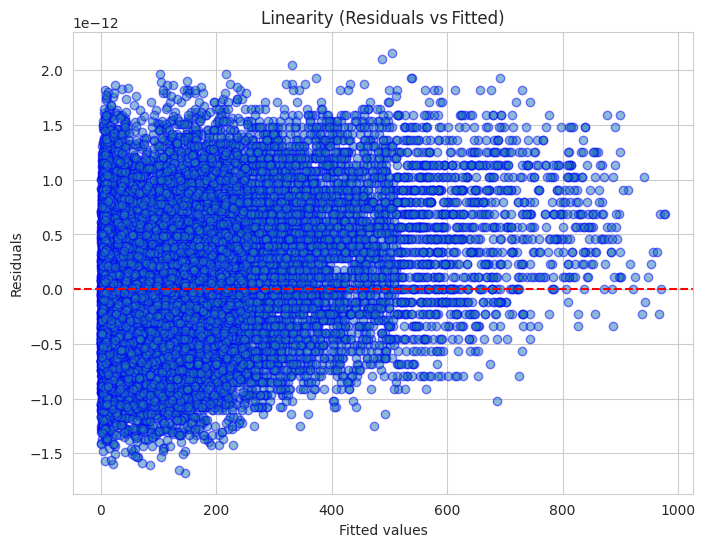

Checking homoscedasticity …


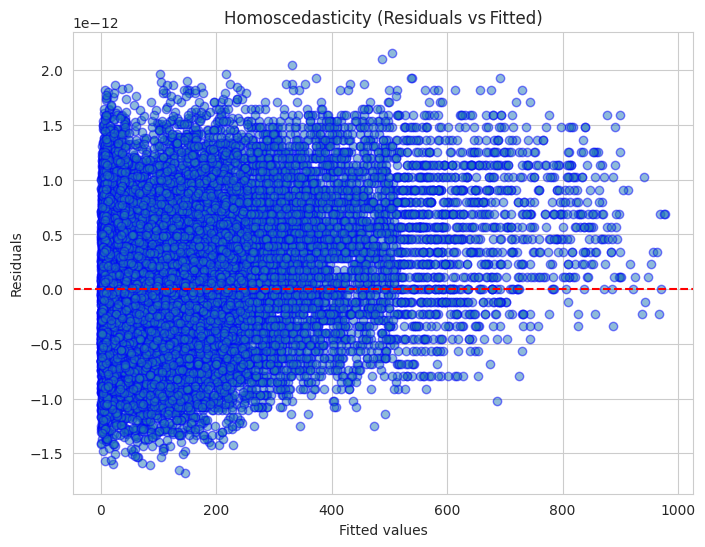

Checking normality …


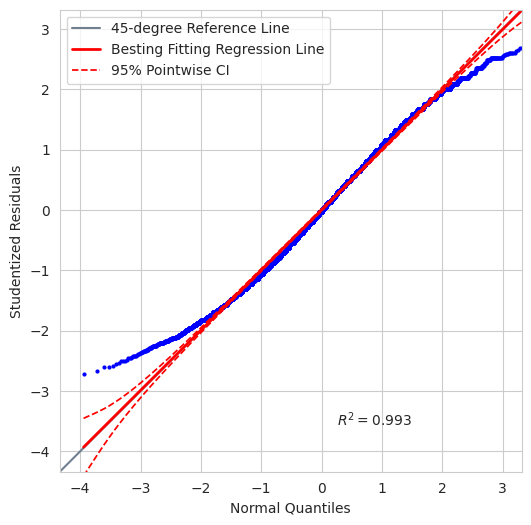

Checking multicollinearity …

All VIF values:
                  Feature         VIF
0                   const  118.536143
1                   atemp  111.314401
2                     hum   46.688410
3               windspeed    1.348256
4                 holiday    1.238884
5              workingday    3.380599
6                  season   18.431523
7              weathersit    1.505536
8                      yr    6.418649
9                    mnth    5.387169
10                     hr    3.512907
11                weekday    3.005982
12               mnth_sin    8.144673
13               mnth_cos   12.663723
14                 hr_sin    9.147576
15                 hr_cos    5.709755
16            weekday_sin    3.162255
17            weekday_cos    3.143812
18              cnt_lag_1   40.396427
19              cnt_lag_2   13.338438
20              cnt_lag_3   13.438380
21             cnt_lag_24    4.005956
22             temp_lag_1  279.032872
23              hum_lag_1   81.687925
24  

,Feature,VIF


In [ ]:
diagnostics = RegressionDiagnostics(model_sota_m)
diagnostics.check_residual_mean()
diagnostics.check_linearity()
diagnostics.check_homoscedasticity()
diagnostics.check_normality()
diagnostics.check_multicollinearity(show=False)

In the final model, we have removed the outliers and highly correlated features. The final model demonstrates the following:
* The model satisfies the assumption of zero-mean residuals.
* The model satisfies the assumption of homoscedasticity.
* The model satisfies the assumption of normality of residuals.
* There is no evidence of severe multicollinearity among the predictors.

(e) Feature transformation on test set

In [ ]:
# Transform the whole dataset for SOTA input
df_input = df[predictor_vars + [response_var]]
df_input, _ = engineer_features(df_input, continuous_vars)

# Remove const from the input DataFrame
selected_feature = [col for col in selected_feature if col != 'const']
df_input[selected_feature].describe(include='all')

,atemp,hum,windspeed,holiday,workingday,season,weathersit,yr,mnth,hr,...,is_morning_rush,is_evening_rush,temp_trend,temp_seasonal,atemp_trend,atemp_seasonal,temp_season_1,temp_season_2,temp_season_3,temp_season_4
count,1.737900e+04,1.737900e+04,1.737900e+04,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,...,17379.000000,17379.000000,1.737900e+04,1.737900e+04,1.737900e+04,1.737900e+04,1.737900e+04,1.737900e+04,1.737900e+04,1.737900e+04
mean,-1.831654e-16,-3.074562e-16,1.537281e-16,0.028770,0.682721,2.501640,1.425283,0.502561,6.537775,11.546752,...,0.125496,0.125784,3.009146e-16,9.812432e-18,-1.046659e-16,2.596206e-17,8.831189e-17,9.158270e-17,-1.700822e-16,-3.924973e-17
std,1.000029e+00,1.000029e+00,1.000029e+00,0.167165,0.465431,1.106918,0.639357,0.500008,3.438776,6.914405,...,0.331290,0.331615,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00
min,-2.768625e+00,-3.251166e+00,-1.553889e+00,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,-2.408618e+00,-1.669885e+00,-2.488109e+00,-1.703134e+00,-5.169454e-01,-5.590840e-01,-5.838353e-01,-5.384753e-01
25%,-8.290895e-01,-7.631431e-01,-6.996886e-01,0.000000,0.000000,2.000000,1.000000,0.000000,4.000000,6.000000,...,0.000000,0.000000,-8.679358e-01,-1.051535e+00,-8.473239e-01,-1.018439e+00,-5.169454e-01,-5.590840e-01,-5.838353e-01,-5.384753e-01
50%,5.251758e-02,1.436398e-02,3.189880e-02,0.000000,1.000000,3.000000,1.000000,1.000000,7.000000,12.000000,...,0.000000,0.000000,3.231474e-02,9.140697e-02,9.055989e-02,-2.348597e-02,-5.169454e-01,-5.590840e-01,-5.838353e-01,-5.384753e-01
75%,8.462549e-01,7.918711e-01,5.198962e-01,0.000000,1.000000,3.000000,2.000000,1.000000,10.000000,18.000000,...,0.000000,0.000000,8.687500e-01,9.921929e-01,8.246824e-01,9.613548e-01,-5.169454e-01,4.119736e-01,1.141310e+00,-5.384753e-01
max,3.050563e+00,1.932215e+00,5.399871e+00,1.000000,1.000000,4.000000,4.000000,1.000000,12.000000,23.000000,...,1.000000,1.000000,2.083518e+00,1.091131e+00,2.401290e+00,1.136300e+00,4.580436e+00,3.244225e+00,2.610878e+00,3.433225e+00


In [ ]:
# Change the order of columns to have the response variable 'cnt', as the first column
cols = df_input.columns.tolist()
cols.insert(0, cols.pop(cols.index('cnt')))
df_input = df_input[cols]
df_input

,cnt,temp,atemp,hum,windspeed,date_index,holiday,workingday,season,weathersit,...,is_morning_rush,is_evening_rush,temp_trend,temp_seasonal,atemp_trend,atemp_seasonal,temp_season_1,temp_season_2,temp_season_3,temp_season_4
0,16,-1.334648,-1.093281,0.947372,-1.553889,0,0,0,1,1,...,0,0,-0.615819,-1.051535,-0.390704,-1.058368,1.182182,-0.559084,-0.583835,-0.538475
1,40,-1.438516,-1.181732,0.895539,-1.553889,0,0,0,1,1,...,0,0,-0.613770,-1.543986,-0.395258,-1.612073,1.040588,-0.559084,-0.583835,-0.538475
2,32,-1.438516,-1.181732,0.895539,-1.553889,0,0,0,1,1,...,0,0,-0.611721,-1.669885,-0.399813,-1.703134,1.040588,-0.559084,-0.583835,-0.538475
3,13,-1.334648,-1.093281,0.636370,-1.553889,0,0,0,1,1,...,0,0,-0.609671,-1.542701,-0.404368,-1.492028,1.182182,-0.559084,-0.583835,-0.538475
4,1,-1.334648,-1.093281,0.636370,-1.553889,0,0,0,1,1,...,0,0,-0.607622,-1.330334,-0.408922,-1.158367,1.182182,-0.559084,-0.583835,-0.538475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,119,-1.230779,-1.269602,-0.141137,-0.211691,730,0,1,1,2,...,0,1,-1.737715,-0.178383,-1.669418,-0.140991,1.323776,-0.559084,-0.583835,-0.538475
17375,89,-1.230779,-1.269602,-0.141137,-0.211691,730,0,1,1,2,...,0,0,-1.749533,-0.585242,-1.672954,-0.544947,1.323776,-0.559084,-0.583835,-0.538475
17376,90,-1.230779,-1.269602,-0.141137,-0.211691,730,0,1,1,1,...,0,0,-1.761351,-1.051535,-1.676489,-1.058368,1.323776,-0.559084,-0.583835,-0.538475
17377,61,-1.230779,-1.181732,-0.348473,-0.456099,730,0,1,1,1,...,0,0,-1.773168,-1.543986,-1.680025,-1.612073,1.323776,-0.559084,-0.583835,-0.538475


In [ ]:
# Add timestamp for the output
df_output = pd.merge(df_input[['cnt'] + selected_feature], df[["timestamp_seconds"]] , left_index=True, right_index=True, how='inner')
df_output

,cnt,atemp,hum,windspeed,holiday,workingday,season,weathersit,yr,mnth,...,is_evening_rush,temp_trend,temp_seasonal,atemp_trend,atemp_seasonal,temp_season_1,temp_season_2,temp_season_3,temp_season_4,timestamp_seconds
0,16,-1.093281,0.947372,-1.553889,0,0,1,1,0,1,...,0,-0.615819,-1.051535,-0.390704,-1.058368,1.182182,-0.559084,-0.583835,-0.538475,1293840000
1,40,-1.181732,0.895539,-1.553889,0,0,1,1,0,1,...,0,-0.613770,-1.543986,-0.395258,-1.612073,1.040588,-0.559084,-0.583835,-0.538475,1293843600
2,32,-1.181732,0.895539,-1.553889,0,0,1,1,0,1,...,0,-0.611721,-1.669885,-0.399813,-1.703134,1.040588,-0.559084,-0.583835,-0.538475,1293847200
3,13,-1.093281,0.636370,-1.553889,0,0,1,1,0,1,...,0,-0.609671,-1.542701,-0.404368,-1.492028,1.182182,-0.559084,-0.583835,-0.538475,1293850800
4,1,-1.093281,0.636370,-1.553889,0,0,1,1,0,1,...,0,-0.607622,-1.330334,-0.408922,-1.158367,1.182182,-0.559084,-0.583835,-0.538475,1293854400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,119,-1.269602,-0.141137,-0.211691,0,1,1,2,1,12,...,1,-1.737715,-0.178383,-1.669418,-0.140991,1.323776,-0.559084,-0.583835,-0.538475,1356980400
17375,89,-1.269602,-0.141137,-0.211691,0,1,1,2,1,12,...,0,-1.749533,-0.585242,-1.672954,-0.544947,1.323776,-0.559084,-0.583835,-0.538475,1356984000
17376,90,-1.269602,-0.141137,-0.211691,0,1,1,1,1,12,...,0,-1.761351,-1.051535,-1.676489,-1.058368,1.323776,-0.559084,-0.583835,-0.538475,1356987600
17377,61,-1.181732,-0.348473,-0.456099,0,1,1,1,1,12,...,0,-1.773168,-1.543986,-1.680025,-1.612073,1.323776,-0.559084,-0.583835,-0.538475,1356991200


In [ ]:
# Export the transformed dataset
df_output.to_csv('hour_transformed.csv', index=False)